In [1]:
%pylab inline

import numpy as np
import torch

from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch import optim
from torch import nn
from torchvision.datasets import CIFAR10
from torchvision import transforms
from densenet import DenseNet

from datetime import datetime

print('torch version:', torch.__version__)

Populating the interactive namespace from numpy and matplotlib
torch version: 0.1.12+ccd5f4d


# Configuration

In [2]:
EPOCH = 2000
BATCH_SIZE = 16
PRINT_TRAINING_INTERVAL = 1000
CUDA = True

# Data

In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


to_pil = transforms.ToPILImage()


trainset = CIFAR10('./CIFAR10', train=True,  transform=transform, download=True)
testset  = CIFAR10('./CIFAR10', train=False, transform=transform, download=True)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


train_x = trainset.train_data
train_y = np.array(trainset.train_labels)
test_x = testset.test_data
test_y = np.array(testset.test_labels)

print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

Files already downloaded and verified
Files already downloaded and verified
train_x: (50000, 32, 32, 3)
train_y: (50000,)
test_x: (10000, 32, 32, 3)
test_y: (10000,)


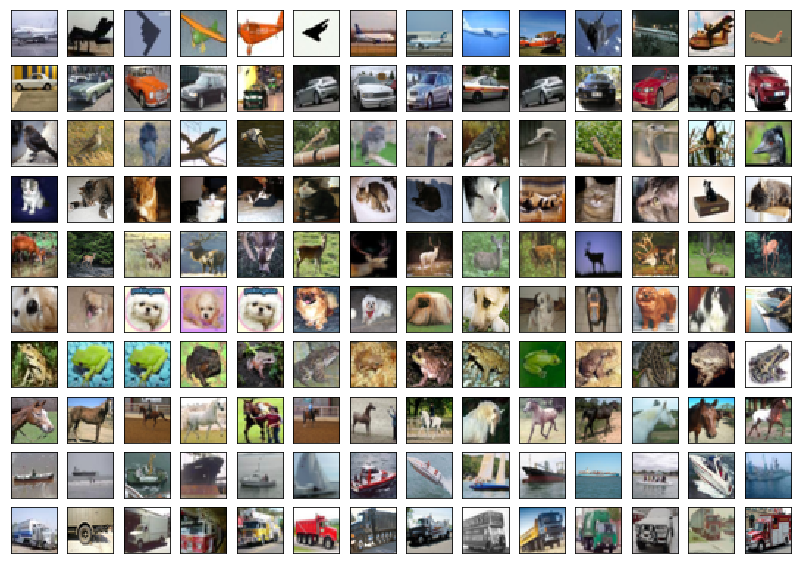

In [4]:
def show_samples(x, y):
    # Convert Tensor to Numpy Array
    if isinstance(x, torch.Tensor):
        x = x.cpu().numpy().transpose(0, 2, 3, 1)
        x = (x - x.min()) / (x.max() - x.min())
        x = 1 - x
        x *= 255
        
        x = x.astype('int').astype('float32')
        y = y.cpu().numpy()
    
    x, y = np.array(x), np.array(y)
    labels = np.unique(y)
    
    fig, subplots = pylab.subplots(len(labels), 14, figsize=(14, 10)) # subplots(y축, x축 갯수)
    subplots = subplots.T.reshape(-1)

    for i, p in enumerate(subplots):
        target = x[y == labels[i%len(labels)]]

        idx = np.random.randint(target.shape[0])
        d = target[idx]
        p.get_xaxis().set_visible(False)
        p.get_yaxis().set_visible(False)
        p.imshow(d)
        
show_samples(test_loader.dataset.test_data, test_loader.dataset.test_labels)

## Tools

In [9]:
def evaluate():
    start_t = datetime.now()
    n_total_correct = 0
    total_duration = 0
    N = len(test_loader.dataset)

    for i, (x_sample, y_true) in enumerate(test_loader):
        start_t = datetime.now()
        x_sample, y_true = Variable(x_sample).cuda(), Variable(y_true).cuda()

        y_pred = model(x_sample)
        
        # Accuracy
        _, y_pred = torch.max(y_pred.data, 1)
        n_correct = torch.sum(y_pred == y_true.data)
        n_total_correct += n_correct
        
        # Time
        duration = (datetime.now() - start_t).total_seconds()
        total_duration += duration

#     print(f'[{total_duration/N:<6.2}] accuracy:', n_total_correct/N)
    return n_total_correct/N

def save_model(model, epoch):
    checkpoint = {
        'model': model.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint, 'model.pt')

# Model

In [6]:
np.random.seed(0)
model = DenseNet(24, 0.005, n_class=10, fc_size=12320, blocks=[32, 24, 32])

model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [7]:
# checkpoint = torch.load('model.pt')
# model.load_state_dict(checkpoi
        x *= 255
        
        x = x.astype('int').astype('float32')
        y = y.cpu().numpy()
    
    x, y = np.array(x), np.array(y)
    labels = np.unique(y)nt['model'])

# Train

In [13]:
def foo():
    y_pred = model(x_sample)
    
    
%time foo()

CPU times: user 64 ms, sys: 28 ms, total: 92 ms
Wall time: 81.4 ms


In [10]:
logs = {'loss': list(), 'duration': list()}
step = 0

global_test_acc = 0

for epoch in range(0, EPOCH):
    for x_sample, y_sample in train_loader:
        start_t = datetime.now()
        x_sample, y_sample = Variable(x_sample).cuda(), Variable(y_sample).cuda()

        # Init Gradients
        optimizer.zero_grad()

        # Feedforward    
        y_pred = model(x_sample)
        loss = criterion(y_pred, y_sample)
        loss.backward()
for epoch in range(0, EPOCH):
    for x_sample, y_sample in train_loader:
        start_t = datetime.now()
        optimizer.step()

        # Add Step
        step += 1

        # Logging
        loss = loss.data.cpu().numpy()[0]
        duration = (datetime.now() - start_t).total_seconds()
        logs['loss'].append(loss)
        logs['duration'].append(duration)
        
        if step % PRINT_TRAINING_INTERVAL == 0:
            time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            test_acc = evaluate()
            loss = np.mean(logs['loss'][-PRINT_TRAINING_INTERVAL:])
            duration = np.sum(logs['duration'][-PRINT_TRAINING_INTERVAL:])
            print(f'{time} | epoch:{epoch} | step:{step} | loss:{loss:<8.4} | test acc:{test_acc:8.4}')
            
            if test_acc > global_test_acc:
                global_test_acc = test_acc
                save_model(model, epoch)

2017-08-16 11:09:41 | epoch:0 | step:1000 | loss:1.548    | test acc:  0.4471
2017-08-16 11:14:06 | epoch:0 | step:2000 | loss:1.417    | test acc:  0.5113
2017-08-16 11:18:31 | epoch:0 | step:3000 | loss:1.25     | test acc:  0.5698
2017-08-16 11:22:56 | epoch:1 | step:4000 | loss:1.127    | test acc:  0.6225
2017-08-16 11:27:22 | epoch:1 | step:5000 | loss:1.052    | test acc:  0.6268
2017-08-16 11:31:48 | epoch:1 | step:6000 | loss:1.023    | test acc:  0.6388
2017-08-16 11:36:14 | epoch:2 | step:7000 | loss:0.9644   | test acc:  0.6618
2017-08-16 11:40:40 | epoch:2 | step:8000 | loss:0.9154   | test acc:  0.6736
2017-08-16 11:45:06 | epoch:2 | step:9000 | loss:0.8929   | test acc:   0.689
2017-08-16 11:49:32 | epoch:3 | step:10000 | loss:0.8422   | test acc:  0.7026
2017-08-16 11:53:57 | epoch:3 | step:11000 | loss:0.8152   | test acc:  0.7002
2017-08-16 11:58:23 | epoch:3 | step:12000 | loss:0.8002   | test acc:  0.7167
2017-08-16 12:02:49 | epoch:4 | step:13000 | loss:0.7634   | 

2017-08-16 18:44:09 | epoch:33 | step:104000 | loss:0.1282   | test acc:  0.8067
2017-08-16 18:48:33 | epoch:33 | step:105000 | loss:0.1488   | test acc:  0.8111
2017-08-16 18:52:57 | epoch:33 | step:106000 | loss:0.1526   | test acc:  0.8242
2017-08-16 18:57:21 | epoch:34 | step:107000 | loss:0.1359   | test acc:  0.8159
2017-08-16 19:01:45 | epoch:34 | step:108000 | loss:0.1479   | test acc:  0.8205
2017-08-16 19:06:09 | epoch:34 | step:109000 | loss:0.1503   | test acc:  0.8171
2017-08-16 19:10:33 | epoch:35 | step:110000 | loss:0.1277   | test acc:  0.8202
2017-08-16 19:14:57 | epoch:35 | step:111000 | loss:0.1284   | test acc:  0.8136
2017-08-16 19:19:21 | epoch:35 | step:112000 | loss:0.1424   | test acc:  0.8186
2017-08-16 19:23:45 | epoch:36 | step:113000 | loss:0.1303   | test acc:  0.8212
2017-08-16 19:28:09 | epoch:36 | step:114000 | loss:0.1206   | test acc:  0.8176
2017-08-16 19:32:33 | epoch:36 | step:115000 | loss:0.1337   | test acc:  0.8184
2017-08-16 19:36:56 | epoch:

2017-08-17 02:14:16 | epoch:65 | step:206000 | loss:0.07464  | test acc:  0.8188
2017-08-17 02:18:40 | epoch:66 | step:207000 | loss:0.06316  | test acc:  0.8222
2017-08-17 02:23:05 | epoch:66 | step:208000 | loss:0.0598   | test acc:  0.8163
2017-08-17 02:27:29 | epoch:66 | step:209000 | loss:0.06827  | test acc:   0.814
2017-08-17 02:31:53 | epoch:67 | step:210000 | loss:0.06902  | test acc:  0.8152
2017-08-17 02:36:17 | epoch:67 | step:211000 | loss:0.05717  | test acc:   0.819
2017-08-17 02:40:42 | epoch:67 | step:212000 | loss:0.06937  | test acc:  0.8239
2017-08-17 02:45:06 | epoch:68 | step:213000 | loss:0.06003  | test acc:  0.8191
2017-08-17 02:49:30 | epoch:68 | step:214000 | loss:0.06457  | test acc:  0.8212
2017-08-17 02:53:54 | epoch:68 | step:215000 | loss:0.06646  | test acc:  0.8187
2017-08-17 02:58:19 | epoch:69 | step:216000 | loss:0.06375  | test acc:  0.8219
2017-08-17 03:02:43 | epoch:69 | step:217000 | loss:0.064    | test acc:  0.8229
2017-08-17 03:07:07 | epoch:

2017-08-17 09:43:24 | epoch:98 | step:308000 | loss:0.05395  | test acc:  0.8174
2017-08-17 09:47:49 | epoch:98 | step:309000 | loss:0.04629  | test acc:  0.8191
2017-08-17 09:52:13 | epoch:99 | step:310000 | loss:0.04352  | test acc:  0.8198
2017-08-17 09:56:38 | epoch:99 | step:311000 | loss:0.05021  | test acc:   0.825
2017-08-17 10:01:01 | epoch:99 | step:312000 | loss:0.05021  | test acc:  0.8208
2017-08-17 10:05:26 | epoch:100 | step:313000 | loss:0.05202  | test acc:  0.8225
2017-08-17 10:09:50 | epoch:100 | step:314000 | loss:0.04657  | test acc:  0.8259
2017-08-17 10:14:14 | epoch:100 | step:315000 | loss:0.05056  | test acc:  0.8256
2017-08-17 10:18:38 | epoch:101 | step:316000 | loss:0.03749  | test acc:  0.8227
2017-08-17 10:23:03 | epoch:101 | step:317000 | loss:0.04907  | test acc:  0.8149
2017-08-17 10:27:27 | epoch:101 | step:318000 | loss:0.05046  | test acc:  0.8299
2017-08-17 10:31:51 | epoch:102 | step:319000 | loss:0.04926  | test acc:  0.8214
2017-08-17 10:36:15 |

2017-08-17 17:04:44 | epoch:130 | step:408000 | loss:0.03951  | test acc:  0.8171
2017-08-17 17:09:08 | epoch:130 | step:409000 | loss:0.03634  | test acc:  0.8229
2017-08-17 17:13:32 | epoch:131 | step:410000 | loss:0.04136  | test acc:   0.825
2017-08-17 17:17:56 | epoch:131 | step:411000 | loss:0.0364   | test acc:  0.8226
2017-08-17 17:22:20 | epoch:131 | step:412000 | loss:0.03177  | test acc:  0.8229
2017-08-17 17:26:44 | epoch:132 | step:413000 | loss:0.03724  | test acc:  0.8175
2017-08-17 17:31:08 | epoch:132 | step:414000 | loss:0.04094  | test acc:  0.8232
2017-08-17 17:35:32 | epoch:132 | step:415000 | loss:0.03426  | test acc:  0.8227
2017-08-17 17:39:55 | epoch:133 | step:416000 | loss:0.03717  | test acc:  0.8194
2017-08-17 17:44:19 | epoch:133 | step:417000 | loss:0.03503  | test acc:   0.826
2017-08-17 17:48:42 | epoch:133 | step:418000 | loss:0.03246  | test acc:  0.8249
2017-08-17 17:53:06 | epoch:134 | step:419000 | loss:0.04373  | test acc:    0.82
2017-08-17 17:57

2017-08-18 00:24:37 | epoch:162 | step:508000 | loss:0.03062  | test acc:  0.8167
2017-08-18 00:29:02 | epoch:162 | step:509000 | loss:0.02868  | test acc:  0.8268
2017-08-18 00:33:27 | epoch:163 | step:510000 | loss:0.03146  | test acc:   0.823
2017-08-18 00:37:51 | epoch:163 | step:511000 | loss:0.03654  | test acc:  0.8283
2017-08-18 00:42:16 | epoch:163 | step:512000 | loss:0.03196  | test acc:    0.83
2017-08-18 00:46:41 | epoch:164 | step:513000 | loss:0.02729  | test acc:   0.825
2017-08-18 00:51:05 | epoch:164 | step:514000 | loss:0.02595  | test acc:  0.8226
2017-08-18 00:55:30 | epoch:164 | step:515000 | loss:0.03833  | test acc:  0.8258
2017-08-18 00:59:54 | epoch:165 | step:516000 | loss:0.03312  | test acc:  0.8254
2017-08-18 01:04:18 | epoch:165 | step:517000 | loss:0.0306   | test acc:  0.8224
2017-08-18 01:08:43 | epoch:165 | step:518000 | loss:0.03039  | test acc:  0.8244
2017-08-18 01:13:07 | epoch:166 | step:519000 | loss:0.03129  | test acc:  0.8297
2017-08-18 01:17

2017-08-18 07:45:41 | epoch:194 | step:608000 | loss:0.02774  | test acc:  0.8295
2017-08-18 07:50:06 | epoch:194 | step:609000 | loss:0.03108  | test acc:  0.8209
2017-08-18 07:54:30 | epoch:195 | step:610000 | loss:0.02944  | test acc:  0.8255
2017-08-18 07:58:55 | epoch:195 | step:611000 | loss:0.0206   | test acc:   0.828
2017-08-18 08:03:19 | epoch:195 | step:612000 | loss:0.03514  | test acc:  0.8237
2017-08-18 08:07:44 | epoch:196 | step:613000 | loss:0.02826  | test acc:  0.8303
2017-08-18 08:12:08 | epoch:196 | step:614000 | loss:0.02166  | test acc:  0.8281
2017-08-18 08:16:33 | epoch:196 | step:615000 | loss:0.02794  | test acc:  0.8241
2017-08-18 08:20:58 | epoch:197 | step:616000 | loss:0.02864  | test acc:  0.8297
2017-08-18 08:25:22 | epoch:197 | step:617000 | loss:0.02519  | test acc:  0.8231
2017-08-18 08:29:46 | epoch:197 | step:618000 | loss:0.0228   | test acc:  0.8229
2017-08-18 08:34:11 | epoch:198 | step:619000 | loss:0.03095  | test acc:  0.8272
2017-08-18 08:38

2017-08-18 15:05:05 | epoch:226 | step:708000 | loss:0.0251   | test acc:  0.8249
2017-08-18 15:09:29 | epoch:226 | step:709000 | loss:0.0265   | test acc:  0.8294
2017-08-18 15:13:53 | epoch:227 | step:710000 | loss:0.02579  | test acc:  0.8222
2017-08-18 15:18:16 | epoch:227 | step:711000 | loss:0.01958  | test acc:  0.8261
2017-08-18 15:22:40 | epoch:227 | step:712000 | loss:0.03202  | test acc:  0.8261
2017-08-18 15:27:03 | epoch:228 | step:713000 | loss:0.02374  | test acc:  0.8282
2017-08-18 15:31:27 | epoch:228 | step:714000 | loss:0.02589  | test acc:    0.83
2017-08-18 15:35:51 | epoch:228 | step:715000 | loss:0.02134  | test acc:  0.8222
2017-08-18 15:40:14 | epoch:229 | step:716000 | loss:0.02522  | test acc:  0.8285
2017-08-18 15:44:38 | epoch:229 | step:717000 | loss:0.02128  | test acc:  0.8308
2017-08-18 15:49:02 | epoch:229 | step:718000 | loss:0.02409  | test acc:  0.8272
2017-08-18 15:53:26 | epoch:230 | step:719000 | loss:0.02768  | test acc:  0.8298
2017-08-18 15:57

2017-08-18 22:24:18 | epoch:258 | step:808000 | loss:0.02314  | test acc:  0.8308
2017-08-18 22:28:41 | epoch:258 | step:809000 | loss:0.02231  | test acc:  0.8281
2017-08-18 22:33:04 | epoch:259 | step:810000 | loss:0.02719  | test acc:  0.8311
2017-08-18 22:37:27 | epoch:259 | step:811000 | loss:0.02376  | test acc:  0.8253
2017-08-18 22:41:50 | epoch:259 | step:812000 | loss:0.02182  | test acc:  0.8279
2017-08-18 22:46:13 | epoch:260 | step:813000 | loss:0.02373  | test acc:   0.828
2017-08-18 22:50:36 | epoch:260 | step:814000 | loss:0.02679  | test acc:  0.8235
2017-08-18 22:54:59 | epoch:260 | step:815000 | loss:0.01792  | test acc:  0.8293
2017-08-18 22:59:22 | epoch:261 | step:816000 | loss:0.02258  | test acc:  0.8307
2017-08-18 23:03:45 | epoch:261 | step:817000 | loss:0.02742  | test acc:  0.8292
2017-08-18 23:08:08 | epoch:261 | step:818000 | loss:0.0228   | test acc:  0.8264
2017-08-18 23:12:31 | epoch:262 | step:819000 | loss:0.02695  | test acc:  0.8279
2017-08-18 23:16

2017-08-19 05:42:59 | epoch:290 | step:908000 | loss:0.01903  | test acc:  0.8306
2017-08-19 05:47:23 | epoch:290 | step:909000 | loss:0.01988  | test acc:  0.8269
2017-08-19 05:51:46 | epoch:291 | step:910000 | loss:0.01892  | test acc:  0.8256
2017-08-19 05:56:10 | epoch:291 | step:911000 | loss:0.01947  | test acc:  0.8303
2017-08-19 06:00:34 | epoch:291 | step:912000 | loss:0.02702  | test acc:  0.8271
2017-08-19 06:04:58 | epoch:292 | step:913000 | loss:0.02281  | test acc:  0.8309
2017-08-19 06:09:22 | epoch:292 | step:914000 | loss:0.01928  | test acc:  0.8307
2017-08-19 06:13:45 | epoch:292 | step:915000 | loss:0.02175  | test acc:  0.8221
2017-08-19 06:18:09 | epoch:293 | step:916000 | loss:0.01692  | test acc:  0.8289
2017-08-19 06:22:33 | epoch:293 | step:917000 | loss:0.02016  | test acc:  0.8289
2017-08-19 06:26:57 | epoch:293 | step:918000 | loss:0.02101  | test acc:  0.8302
2017-08-19 06:31:21 | epoch:294 | step:919000 | loss:0.02462  | test acc:  0.8243
2017-08-19 06:35

2017-08-19 13:02:51 | epoch:322 | step:1008000 | loss:0.02194  | test acc:  0.8309
2017-08-19 13:07:16 | epoch:322 | step:1009000 | loss:0.01782  | test acc:  0.8291
2017-08-19 13:11:40 | epoch:323 | step:1010000 | loss:0.01865  | test acc:  0.8257
2017-08-19 13:16:04 | epoch:323 | step:1011000 | loss:0.02612  | test acc:  0.8283
2017-08-19 13:20:28 | epoch:323 | step:1012000 | loss:0.02307  | test acc:  0.8286
2017-08-19 13:24:53 | epoch:324 | step:1013000 | loss:0.01683  | test acc:  0.8317
2017-08-19 13:29:18 | epoch:324 | step:1014000 | loss:0.02367  | test acc:   0.827
2017-08-19 13:33:42 | epoch:324 | step:1015000 | loss:0.0222   | test acc:    0.83
2017-08-19 13:38:07 | epoch:325 | step:1016000 | loss:0.01583  | test acc:  0.8306
2017-08-19 13:42:31 | epoch:325 | step:1017000 | loss:0.01858  | test acc:  0.8245
2017-08-19 13:46:56 | epoch:325 | step:1018000 | loss:0.02353  | test acc:   0.828
2017-08-19 13:51:21 | epoch:326 | step:1019000 | loss:0.02197  | test acc:  0.8291
2017

2017-08-19 20:20:09 | epoch:354 | step:1107000 | loss:0.01498  | test acc:  0.8281
2017-08-19 20:24:34 | epoch:354 | step:1108000 | loss:0.01729  | test acc:  0.8248
2017-08-19 20:28:58 | epoch:354 | step:1109000 | loss:0.02271  | test acc:    0.83
2017-08-19 20:33:22 | epoch:355 | step:1110000 | loss:0.01522  | test acc:  0.8335
2017-08-19 20:37:46 | epoch:355 | step:1111000 | loss:0.0151   | test acc:  0.8304
2017-08-19 20:42:10 | epoch:355 | step:1112000 | loss:0.01868  | test acc:  0.8313
2017-08-19 20:46:34 | epoch:356 | step:1113000 | loss:0.02485  | test acc:  0.8338
2017-08-19 20:50:58 | epoch:356 | step:1114000 | loss:0.01573  | test acc:  0.8322
2017-08-19 20:55:22 | epoch:356 | step:1115000 | loss:0.02167  | test acc:   0.833
2017-08-19 20:59:46 | epoch:357 | step:1116000 | loss:0.01579  | test acc:  0.8274
2017-08-19 21:04:10 | epoch:357 | step:1117000 | loss:0.01814  | test acc:  0.8303
2017-08-19 21:08:34 | epoch:357 | step:1118000 | loss:0.01796  | test acc:  0.8241
2017

2017-08-20 03:36:38 | epoch:385 | step:1206000 | loss:0.01546  | test acc:  0.8319
2017-08-20 03:41:03 | epoch:386 | step:1207000 | loss:0.01464  | test acc:  0.8267
2017-08-20 03:45:28 | epoch:386 | step:1208000 | loss:0.01511  | test acc:  0.8303
2017-08-20 03:49:53 | epoch:386 | step:1209000 | loss:0.02392  | test acc:  0.8288
2017-08-20 03:54:19 | epoch:387 | step:1210000 | loss:0.02168  | test acc:  0.8308
2017-08-20 03:58:44 | epoch:387 | step:1211000 | loss:0.01319  | test acc:  0.8306
2017-08-20 04:03:09 | epoch:387 | step:1212000 | loss:0.01619  | test acc:  0.8294
2017-08-20 04:07:34 | epoch:388 | step:1213000 | loss:0.0204   | test acc:  0.8254
2017-08-20 04:11:59 | epoch:388 | step:1214000 | loss:0.01308  | test acc:  0.8312
2017-08-20 04:16:24 | epoch:388 | step:1215000 | loss:0.01881  | test acc:  0.8273
2017-08-20 04:20:49 | epoch:389 | step:1216000 | loss:0.01697  | test acc:  0.8237
2017-08-20 04:25:14 | epoch:389 | step:1217000 | loss:0.01444  | test acc:  0.8316
2017

2017-08-20 10:54:49 | epoch:417 | step:1305000 | loss:0.01973  | test acc:  0.8298
2017-08-20 10:59:13 | epoch:417 | step:1306000 | loss:0.02305  | test acc:  0.8288
2017-08-20 11:03:38 | epoch:418 | step:1307000 | loss:0.01667  | test acc:  0.8285
2017-08-20 11:08:02 | epoch:418 | step:1308000 | loss:0.01523  | test acc:  0.8293
2017-08-20 11:12:25 | epoch:418 | step:1309000 | loss:0.02028  | test acc:  0.8234
2017-08-20 11:16:50 | epoch:419 | step:1310000 | loss:0.01337  | test acc:  0.8306
2017-08-20 11:21:13 | epoch:419 | step:1311000 | loss:0.01884  | test acc:  0.8301
2017-08-20 11:25:37 | epoch:419 | step:1312000 | loss:0.0171   | test acc:   0.829
2017-08-20 11:30:01 | epoch:420 | step:1313000 | loss:0.02176  | test acc:  0.8273
2017-08-20 11:34:24 | epoch:420 | step:1314000 | loss:0.01185  | test acc:  0.8309
2017-08-20 11:38:48 | epoch:420 | step:1315000 | loss:0.02423  | test acc:  0.8303
2017-08-20 11:43:11 | epoch:421 | step:1316000 | loss:0.0174   | test acc:  0.8339
2017

2017-08-20 18:09:17 | epoch:449 | step:1404000 | loss:0.01406  | test acc:  0.8324
2017-08-20 18:13:40 | epoch:449 | step:1405000 | loss:0.02011  | test acc:  0.8304
2017-08-20 18:18:03 | epoch:449 | step:1406000 | loss:0.01463  | test acc:  0.8317
2017-08-20 18:22:26 | epoch:450 | step:1407000 | loss:0.01524  | test acc:  0.8256
2017-08-20 18:26:49 | epoch:450 | step:1408000 | loss:0.01666  | test acc:   0.838
2017-08-20 18:31:11 | epoch:450 | step:1409000 | loss:0.01673  | test acc:  0.8291
2017-08-20 18:35:34 | epoch:451 | step:1410000 | loss:0.01909  | test acc:  0.8282
2017-08-20 18:39:57 | epoch:451 | step:1411000 | loss:0.02066  | test acc:  0.8281
2017-08-20 18:44:20 | epoch:451 | step:1412000 | loss:0.01952  | test acc:  0.8304
2017-08-20 18:48:43 | epoch:452 | step:1413000 | loss:0.01359  | test acc:  0.8296
2017-08-20 18:53:06 | epoch:452 | step:1414000 | loss:0.01694  | test acc:  0.8291
2017-08-20 18:57:29 | epoch:452 | step:1415000 | loss:0.01796  | test acc:  0.8324
2017

2017-08-21 01:21:59 | epoch:480 | step:1503000 | loss:0.01919  | test acc:  0.8299
2017-08-21 01:26:24 | epoch:481 | step:1504000 | loss:0.01677  | test acc:  0.8304
2017-08-21 01:30:48 | epoch:481 | step:1505000 | loss:0.01373  | test acc:  0.8307
2017-08-21 01:35:13 | epoch:481 | step:1506000 | loss:0.01119  | test acc:  0.8301
2017-08-21 01:39:37 | epoch:482 | step:1507000 | loss:0.01482  | test acc:  0.8318
2017-08-21 01:44:01 | epoch:482 | step:1508000 | loss:0.01275  | test acc:   0.831
2017-08-21 01:48:25 | epoch:482 | step:1509000 | loss:0.01855  | test acc:  0.8282
2017-08-21 01:52:49 | epoch:483 | step:1510000 | loss:0.01169  | test acc:  0.8279
2017-08-21 01:57:13 | epoch:483 | step:1511000 | loss:0.01792  | test acc:  0.8333
2017-08-21 02:01:38 | epoch:483 | step:1512000 | loss:0.01118  | test acc:  0.8313
2017-08-21 02:06:02 | epoch:484 | step:1513000 | loss:0.01553  | test acc:  0.8311
2017-08-21 02:10:27 | epoch:484 | step:1514000 | loss:0.01703  | test acc:  0.8277
2017

2017-08-21 08:36:07 | epoch:512 | step:1602000 | loss:0.01893  | test acc:  0.8379
2017-08-21 08:40:30 | epoch:512 | step:1603000 | loss:0.01402  | test acc:  0.8328
2017-08-21 08:44:53 | epoch:513 | step:1604000 | loss:0.0137   | test acc:  0.8315
2017-08-21 08:49:16 | epoch:513 | step:1605000 | loss:0.01304  | test acc:  0.8311
2017-08-21 08:53:40 | epoch:513 | step:1606000 | loss:0.0182   | test acc:  0.8288
2017-08-21 08:58:03 | epoch:514 | step:1607000 | loss:0.01466  | test acc:  0.8303
2017-08-21 09:02:26 | epoch:514 | step:1608000 | loss:0.01523  | test acc:  0.8281
2017-08-21 09:06:50 | epoch:514 | step:1609000 | loss:0.01569  | test acc:  0.8339
2017-08-21 09:11:13 | epoch:515 | step:1610000 | loss:0.01489  | test acc:  0.8316
2017-08-21 09:15:36 | epoch:515 | step:1611000 | loss:0.01546  | test acc:   0.827
2017-08-21 09:19:59 | epoch:515 | step:1612000 | loss:0.01333  | test acc:  0.8301
2017-08-21 09:24:22 | epoch:516 | step:1613000 | loss:0.01674  | test acc:  0.8276
2017

2017-08-21 15:50:28 | epoch:544 | step:1701000 | loss:0.01558  | test acc:  0.8334
2017-08-21 15:54:51 | epoch:544 | step:1702000 | loss:0.01754  | test acc:   0.835
2017-08-21 15:59:14 | epoch:544 | step:1703000 | loss:0.01869  | test acc:  0.8322
2017-08-21 16:03:37 | epoch:545 | step:1704000 | loss:0.01618  | test acc:  0.8363
2017-08-21 16:07:59 | epoch:545 | step:1705000 | loss:0.01701  | test acc:  0.8314
2017-08-21 16:12:22 | epoch:545 | step:1706000 | loss:0.0106   | test acc:  0.8308
2017-08-21 16:16:44 | epoch:546 | step:1707000 | loss:0.01112  | test acc:  0.8292
2017-08-21 16:21:07 | epoch:546 | step:1708000 | loss:0.0152   | test acc:  0.8348
2017-08-21 16:25:29 | epoch:546 | step:1709000 | loss:0.01701  | test acc:  0.8326
2017-08-21 16:29:52 | epoch:547 | step:1710000 | loss:0.01211  | test acc:  0.8325
2017-08-21 16:34:15 | epoch:547 | step:1711000 | loss:0.01579  | test acc:  0.8345
2017-08-21 16:38:37 | epoch:547 | step:1712000 | loss:0.01508  | test acc:  0.8334
2017

2017-08-21 23:03:41 | epoch:575 | step:1800000 | loss:0.01099  | test acc:  0.8309
2017-08-21 23:08:03 | epoch:576 | step:1801000 | loss:0.01153  | test acc:  0.8306
2017-08-21 23:12:25 | epoch:576 | step:1802000 | loss:0.01354  | test acc:  0.8327
2017-08-21 23:16:47 | epoch:576 | step:1803000 | loss:0.01391  | test acc:  0.8364
2017-08-21 23:21:08 | epoch:577 | step:1804000 | loss:0.01595  | test acc:  0.8277
2017-08-21 23:25:35 | epoch:577 | step:1805000 | loss:0.02001  | test acc:   0.833
2017-08-21 23:30:03 | epoch:577 | step:1806000 | loss:0.01513  | test acc:  0.8368
2017-08-21 23:34:31 | epoch:578 | step:1807000 | loss:0.01661  | test acc:  0.8316
2017-08-21 23:38:58 | epoch:578 | step:1808000 | loss:0.01381  | test acc:  0.8355
2017-08-21 23:43:26 | epoch:578 | step:1809000 | loss:0.01311  | test acc:  0.8318
2017-08-21 23:47:53 | epoch:579 | step:1810000 | loss:0.01019  | test acc:  0.8327
2017-08-21 23:52:21 | epoch:579 | step:1811000 | loss:0.01365  | test acc:  0.8319
2017

2017-08-22 06:20:53 | epoch:607 | step:1899000 | loss:0.01595  | test acc:  0.8351
2017-08-22 06:25:17 | epoch:607 | step:1900000 | loss:0.01389  | test acc:  0.8323
2017-08-22 06:29:41 | epoch:608 | step:1901000 | loss:0.0124   | test acc:  0.8318
2017-08-22 06:34:05 | epoch:608 | step:1902000 | loss:0.01197  | test acc:  0.8367
2017-08-22 06:38:28 | epoch:608 | step:1903000 | loss:0.01798  | test acc:  0.8319
2017-08-22 06:42:52 | epoch:609 | step:1904000 | loss:0.01152  | test acc:  0.8363
2017-08-22 06:47:16 | epoch:609 | step:1905000 | loss:0.01472  | test acc:  0.8347
2017-08-22 06:51:40 | epoch:609 | step:1906000 | loss:0.01721  | test acc:  0.8315
2017-08-22 06:56:03 | epoch:610 | step:1907000 | loss:0.01542  | test acc:  0.8342
2017-08-22 07:00:27 | epoch:610 | step:1908000 | loss:0.01644  | test acc:   0.828
2017-08-22 07:04:51 | epoch:610 | step:1909000 | loss:0.01361  | test acc:  0.8345
2017-08-22 07:09:14 | epoch:611 | step:1910000 | loss:0.01273  | test acc:  0.8285
2017

Process Process-10207:
Process Process-10205:
Process Process-10208:
Process Process-10206:
Traceback (most recent call last):
KeyboardInterrupt
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 35, in _worke

KeyboardInterrupt: 

## Save Model

In [ ]:
def save_model(model, epoch):
    checkpoint = {
        'model': model.state_dict()
    }
    torch.save(checkpoint, 'model.pt')

## Evaluate

In [11]:
evaluate()

0.8263